BSD 2-Clause License

Copyright (c) 2024, Omkar Sabnis

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [ ]:
# Importing libraries required for financial data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import date, datetime, timedelta
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [ ]:
# Importing data from yfinance
nvda = ['NVDA']  # Assigned NVIDIA ticker
start_date = (datetime.now() - timedelta(days=3*365)).strftime('%Y-%m-%d') # Date Range Start - 3 years from today
end_date = date.today().strftime('%Y-%m-%d')  # Date Range End - Today's date
nvda_df = yf.download(nvda, start=start_date, end=end_date)  # Fetching and storing the data in assigned variable

# Print the DataFrame columns to verify
print('\n',"Columns in nvda_df:", nvda_df.columns)
nvda_df.head(3)

[*********************100%%**********************]  1 of 1 completed


 Columns in nvda_df: Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-05,20.500000,20.733000,20.341999,20.636999,20.599764,211435000
2021-08-06,20.524000,20.570000,20.209999,20.365999,20.329252,178497000
2021-08-09,20.445999,20.507999,20.143000,20.295000,20.258381,146443000


In [ ]:
# If there's a MultiIndex (which is possible), flatten it
if isinstance(nvda_df.columns, pd.MultiIndex):
    nvda_df.columns = nvda_df.columns.get_level_values(1)

# Ensure 'Adj Close' is a column in the DataFrame
if 'Adj Close' not in nvda_df.columns:
    raise KeyError("'Adj Close' column is missing from the DataFrame")

# Calculate percentage change and drop NaN values
daily_returns = nvda_df['Adj Close'].pct_change().dropna()  # Ensure we're using the correct column

# Verify the type of daily_returns
print(f"Type of daily_returns: {type(daily_returns)}")
print(daily_returns.head())  # Display first few rows to verify data

Type of daily_returns: <class 'pandas.core.series.Series'>
Date
2021-08-06   -0.013132
2021-08-09   -0.003486
2021-08-10   -0.017689
2021-08-11   -0.011888
2021-08-12    0.010458
Name: Adj Close, dtype: float64


In [ ]:
# VaR Calculation Function
def calculate_var(returns, confidence_level=0.95):
    return returns.quantile(1 - confidence_level)

# Expected Shortfall Calculation Function
def calculate_es(returns, confidence_level=0.95):
    var = calculate_var(returns, confidence_level)
    return returns[returns <= var].mean()

# Calculation of VaR and Expected Shortfall for the Series
var_95 = calculate_var(daily_returns)  # Apply function directly to Series
es_95 = calculate_es(daily_returns)    # Apply function directly to Series

# Sharpe Ratio Calculation Function
def calculate_sharpe_ratio(returns, risk_free_rate=0.01):
    excess_returns = returns.mean() - risk_free_rate
    return excess_returns / returns.std()

# Calculation of Sharpe Ratio
sharpe_ratio = calculate_sharpe_ratio(daily_returns)  # Apply function directly to Series

# Sortino Ratio Calculation Function
def calculate_sortino_ratio(returns, risk_free_rate=0.01):
    excess_returns = returns.mean() - risk_free_rate
    downside_risk = returns[returns < 0].std()
    return excess_returns / downside_risk

# Calculation of Sortino Ratio
sortino_ratio = calculate_sortino_ratio(daily_returns)  # Apply function directly to Series

# Maximum Drawdown Calculation Function
def calculate_max_drawdown(returns):
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

# Calculation of Maximum Drawdown
max_drawdown = calculate_max_drawdown(daily_returns)  # Apply function directly to Series

# S&P 500 Market Returns for Beta Calculation
market_returns = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close'].pct_change().dropna()


# Beta Calculation Function
def calculate_beta(stock_returns, market_returns):
    # Ensure both returns are aligned and have the same length
    aligned_returns = pd.concat([stock_returns, market_returns], axis=1).dropna()
    covariance = np.cov(aligned_returns.iloc[:, 0], aligned_returns.iloc[:, 1])[0, 1]
    market_variance = np.var(aligned_returns.iloc[:, 1])
    return covariance / market_variance

# Calculation of Beta
beta = calculate_beta(daily_returns, market_returns)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Creating and displaying a pandas DataFrame using all the risk metrics created
risk_metrics = pd.DataFrame({
    'VaR_95': [var_95],
    'ES_95': [es_95],
    'Sharpe_Ratio': [sharpe_ratio],
    'Sortino_Ratio': [sortino_ratio],
    'Max_Drawdown': [max_drawdown],
    'Beta': [beta]
})

print(risk_metrics)

     VaR_95     ES_95  Sharpe_Ratio  Sortino_Ratio  Max_Drawdown     Beta
0 -0.052388 -0.067567     -0.205816      -0.363758     -0.663351  2.27842


In [ ]:
#Displaying the risk metrics in a formatted manner

#VaR
print("\n There is a 95 percent chance that NVDA will not lose more than", round(abs(var_95*100),2), "percent of its value in any given day.")
#ES
print("\n On the worst 5 percent of days, the average loss is", round(abs(es_95*100),2), "percent")
#Sharpe Ratio
print("\n The asset has a risk adjusted return that is", round(abs(sharpe_ratio*100),2), "times the risk free rate when considering both positive and negative returns.")
#Sortino Ratio
print("\n The asset has a risk adjusted return that is", round(abs(sortino_ratio*100),2), "times the risk free rate when considering only negative returns.")
#Max Drawdown
print("\n The asset has experienced a maximum loss of", round(abs(max_drawdown*100),2), "percent from its peak to trough.")
#Beta
if beta>1:
    print("\n The asset is",round(abs(beta),2),"times more volatile than the  stock market.")
else:
    pass
    print("\n The asset is",round(abs(beta),2),"less volatile than the stock market.")


 There is a 95 percent chance that NVDA will not lose more than 5.24 percent of its value in any given day.

 On the worst 5 percent of days, the average loss is 6.76 percent

 The asset has a risk adjusted return that is 20.58 times the risk free rate when considering both positive and negative returns.

 The asset has a risk adjusted return that is 36.38 times the risk free rate when considering only negative returns.

 The asset has experienced a maximum loss of 66.34 percent from its peak to trough.

 The asset is 2.28 times more volatile than the  stock market.


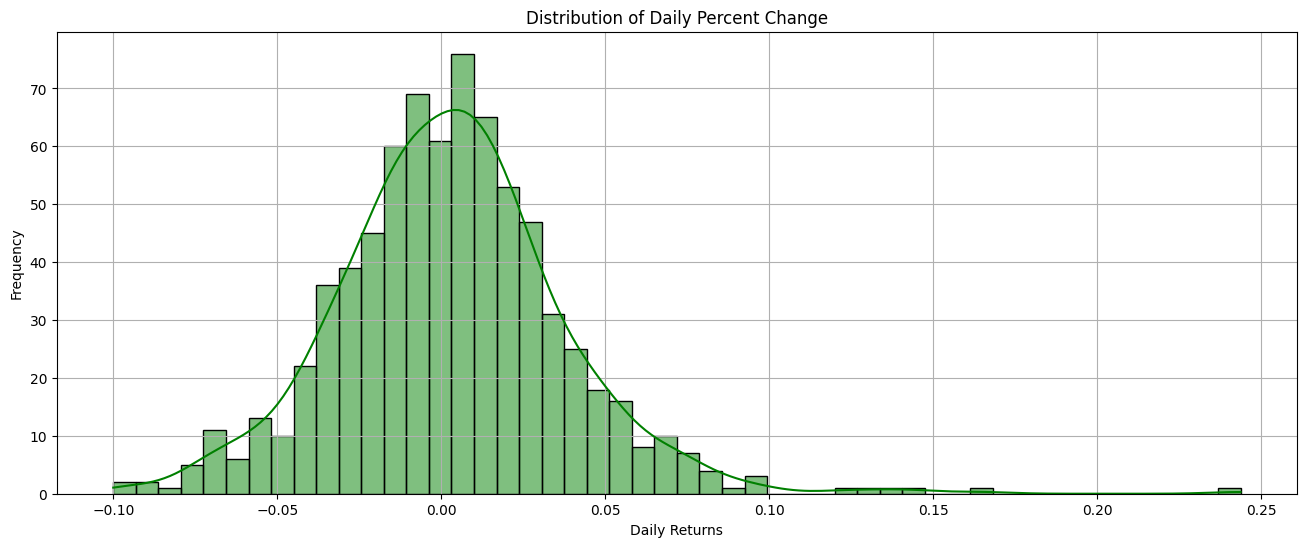

In [ ]:
# Distribution plot of percent change in adjusted close of stock price from 20244-01-01 to today
plt.figure(figsize=(16, 6))
sns.histplot(daily_returns, bins=50, kde=True, color='green')
plt.title('Distribution of Daily Percent Change')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

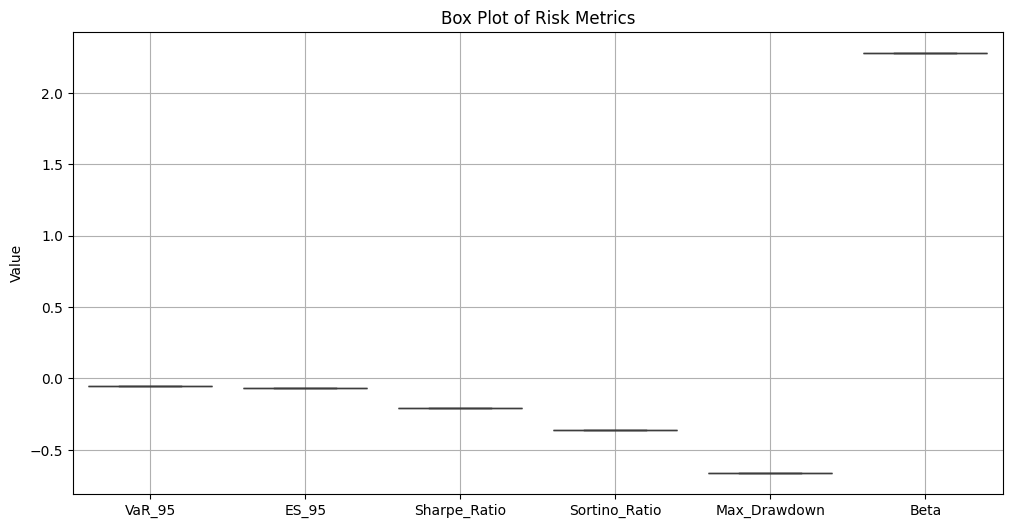

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=risk_metrics)
plt.title('Box Plot of Risk Metrics')
plt.ylabel('Value')
plt.grid(True)
plt.show()